In [83]:
# All necessary packages needed
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import ParameterGrid
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import warnings
from sklearn.exceptions import ConvergenceWarning

In [3]:
# import data
df = pd.read_csv('data/kidney_disease.csv')
df.head()
# EDA - print rows and columns
print("Rows:", df.shape[0], "Columns:", df.shape[1])

Rows: 400 Columns: 26


## Exporatory Data Analysis (EDA)
### (i) About the whole data structure

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              400 non-null    int64  
 1   age             391 non-null    float64
 2   bp              388 non-null    float64
 3   sg              353 non-null    float64
 4   al              354 non-null    float64
 5   su              351 non-null    float64
 6   rbc             248 non-null    object 
 7   pc              335 non-null    object 
 8   pcc             396 non-null    object 
 9   ba              396 non-null    object 
 10  bgr             356 non-null    float64
 11  bu              381 non-null    float64
 12  sc              383 non-null    float64
 13  sod             313 non-null    float64
 14  pot             312 non-null    float64
 15  hemo            348 non-null    float64
 16  pcv             330 non-null    object 
 17  wc              295 non-null    obj

In [5]:
# EDA - target variable type
print("The column Y is discrete") 
print(df['classification'].value_counts())

The column Y is discrete
classification
ckd       248
notckd    150
ckd\t       2
Name: count, dtype: int64


In [6]:
df['classification'] = df['classification'].replace(to_replace={'ckd\t':'ckd', 'notckd':'not ckd'})
print(df['classification'].value_counts())

classification
ckd        250
not ckd    150
Name: count, dtype: int64


Hence we don't need stratified spliting. We will use basic split for train, val and test sets.

In [7]:
# seperate category columns and numerical columns
num_cols = ['age', 'bp', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc']
cat_cols = ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'pe', 'ane', 'appet', 'sg', 'al', 'su']

# check unique values in categorical columns 
for col in cat_cols:
    print(f"{col} has {df[col].unique()}")

rbc has [nan 'normal' 'abnormal']
pc has ['normal' 'abnormal' nan]
pcc has ['notpresent' 'present' nan]
ba has ['notpresent' 'present' nan]
htn has ['yes' 'no' nan]
dm has ['yes' 'no' ' yes' '\tno' '\tyes' nan]
cad has ['no' 'yes' '\tno' nan]
pe has ['no' 'yes' nan]
ane has ['no' 'yes' nan]
appet has ['good' 'poor' nan]
sg has [1.02  1.01  1.005 1.015   nan 1.025]
al has [ 1.  4.  2.  3.  0. nan  5.]
su has [ 0.  3.  4.  1. nan  2.  5.]


### (ii) Then we first take a look at the continuous variables

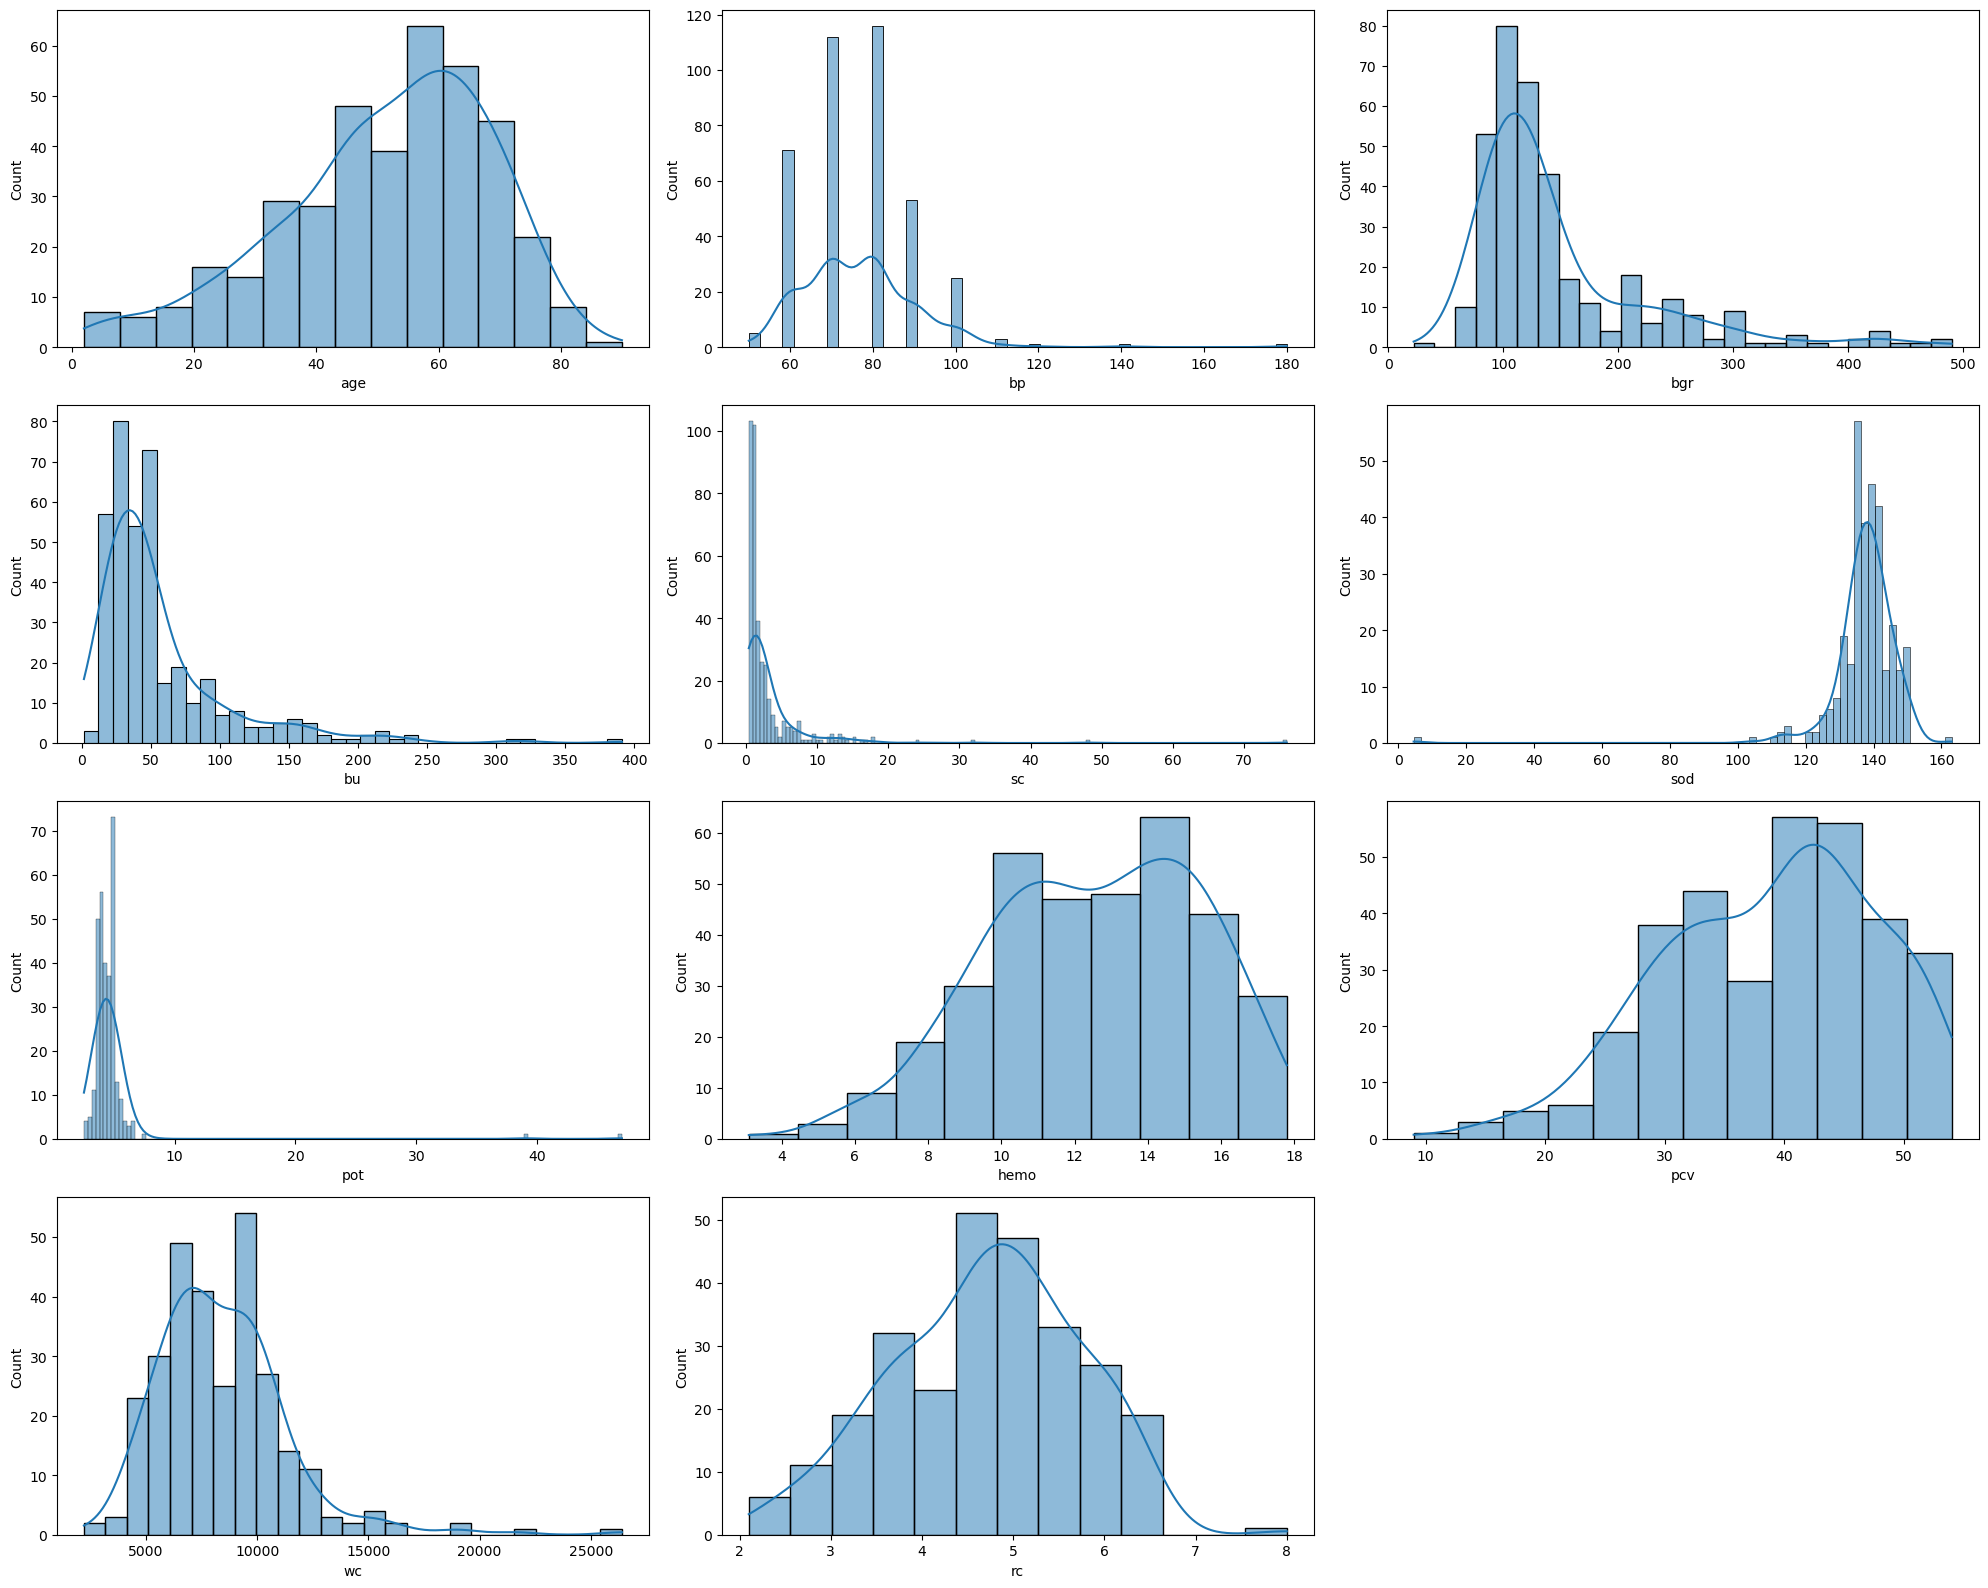

In [8]:
# for the column pcv, wc, rc, there are some strings ? and some values with tab ahead
for column in ['pcv', 'wc', 'rc']:
    df[column] = df[column].str.strip()  # Remove any leading/trailing whitespace
    df[column] = df[column].replace('?',np.nan)
                                    
plt.figure(figsize=(20, 16))
plotnumber = 1

for column in num_cols:
    # Convert to numeric
    df[column] = pd.to_numeric(df[column])
    
    ax = plt.subplot(4, 3, plotnumber)
    sns.histplot(df[column].dropna(), kde=True)  # Use histplot instead of distplot
    plt.xlabel(column)
        
    plotnumber += 1

plt.tight_layout()
plt.show()

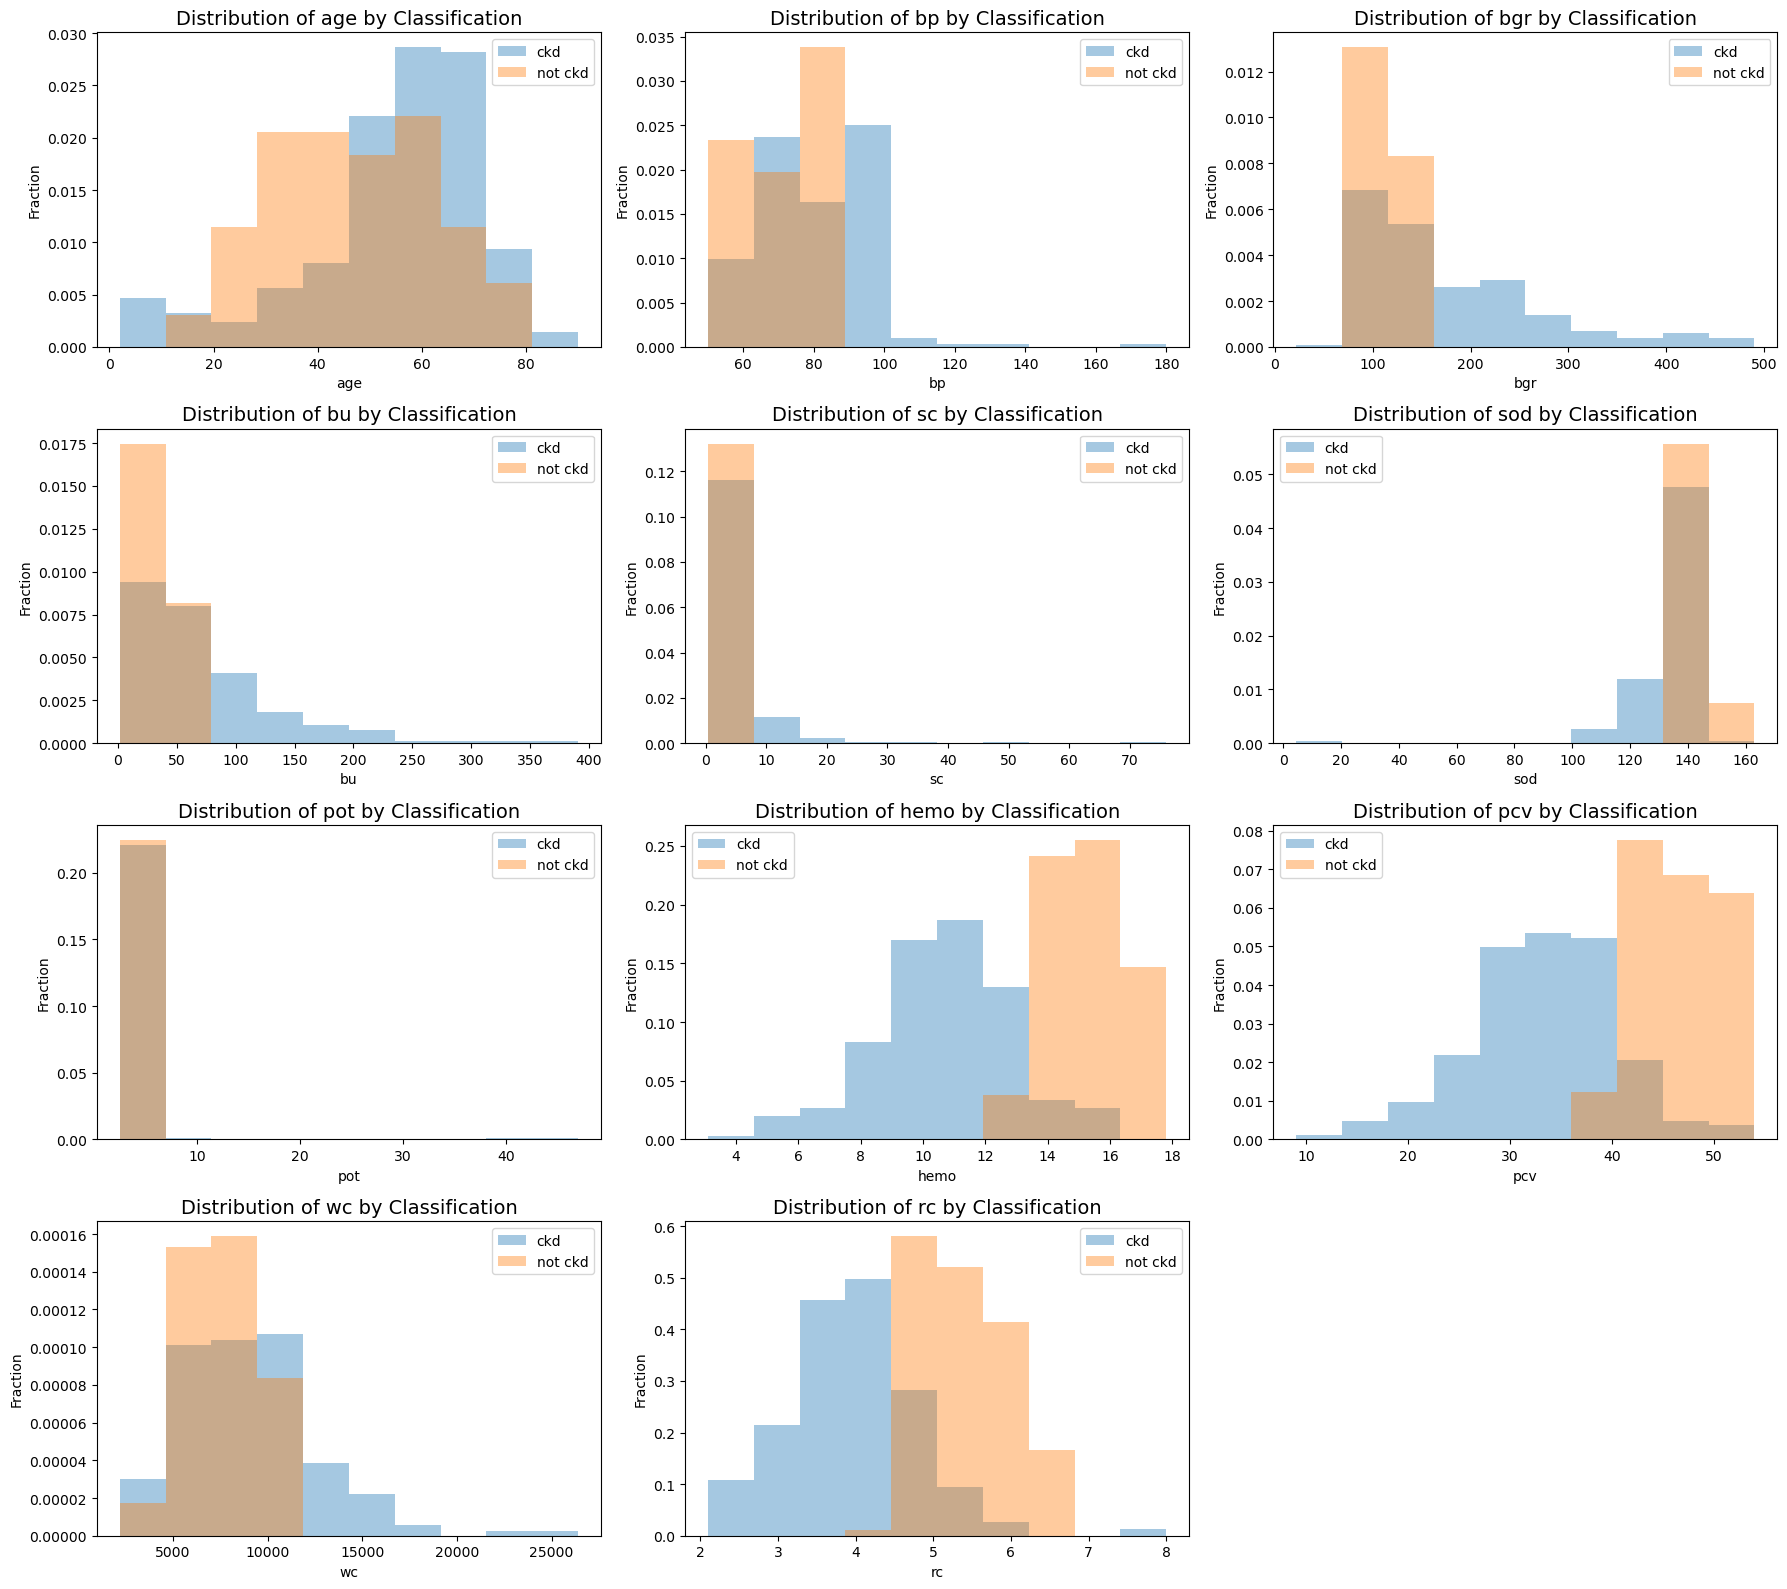

In [9]:
# compare the classification of continous variables
plt.figure(figsize=(18, 16))
categories = df['classification'].unique()

for i, column in enumerate(num_cols):
    plt.subplot(4,3,i+1)  # Create subplots
    bin_range = (df[column].min(), df[column].max())  # Set the bin range for the current column
    
    for c in categories:
        plt.hist(df[df['classification'] == c][column], alpha=0.4, label=c, range = bin_range, density=True)
        plt.legend()
        plt.ylabel('Fraction')
        plt.xlabel(column)
        plt.title(f'Distribution of {column} by Classification', fontsize = 14)

plt.tight_layout()
plt.show()

Now we find that age, bp, bgr, hemo, pcv, wc, rc may have large influence on classification(has disease or not). And we are interested in using bar plot to see if any columns have too many extreme outliers. From above plot, I will choose bgr, bu, wc to investigate.

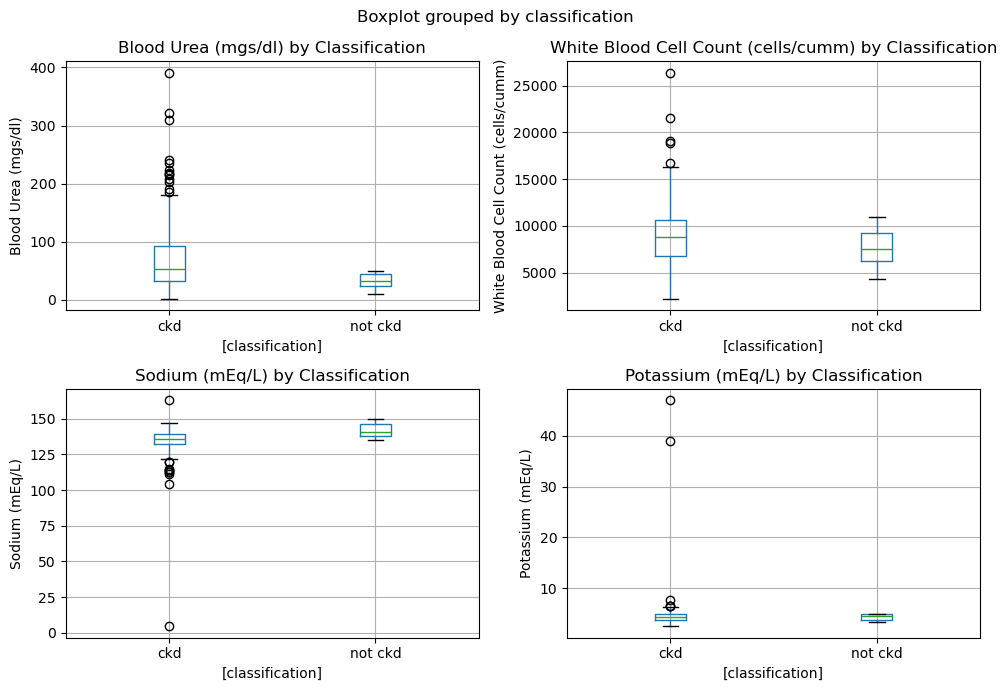

In [10]:
plt.figure(figsize = (10,7))
bar_cols = ['bu', 'wc', 'sod', 'pot']
bar_cols_full = ['Blood Urea (mgs/dl)', 'White Blood Cell Count (cells/cumm)', 'Sodium (mEq/L)', 'Potassium (mEq/L)']
for i, col in enumerate(bar_cols):
    plt.subplot(2,2,i+1)
    df[[col, 'classification']].boxplot(by = 'classification', ax = plt.gca())
    plt.title(f'{bar_cols_full[i]} by Classification')
    plt.ylabel(bar_cols_full[i])

plt.tight_layout()
plt.show()

Next, I am going to visualize some distribution of some attributes across different classidication by violin plot. Here I choose age, hemo, pcv and rc since they have large gap between two distributions from 

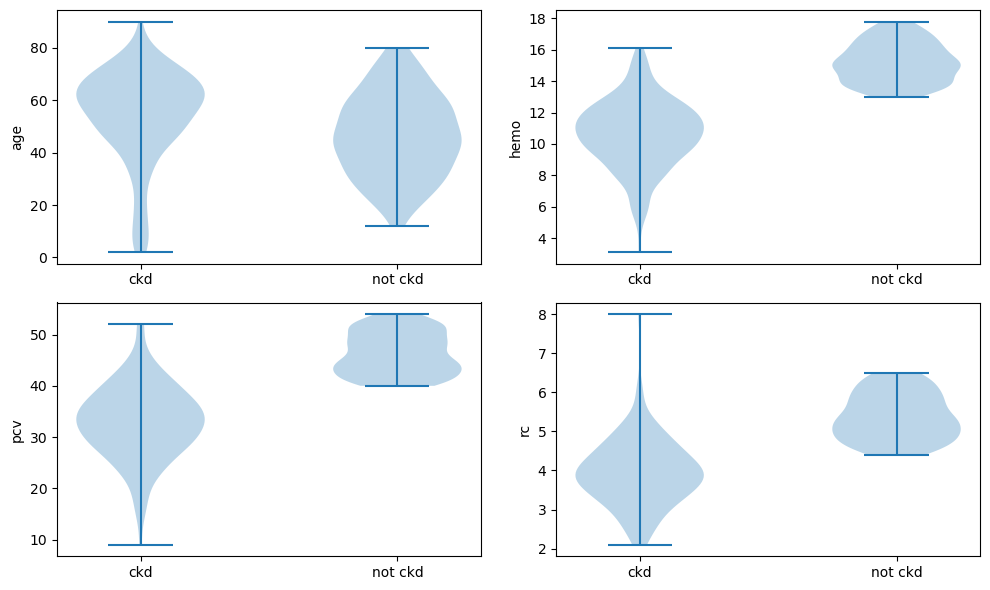

In [11]:
# violin plot
plt.figure(figsize = (10,6))
vio_cols = ['age', 'hemo', 'pcv', 'rc']

for i, col in enumerate(vio_cols):
    plt.subplot(2,2,i+1)
    plt.violinplot(dataset = [df[col][df['classification'] == 'ckd'].dropna().values,
                              df[col][df['classification'] == 'not ckd'].dropna().values]) # dropna to deal with missing values
    plt.xticks([1,2], ['ckd', 'not ckd'])
    plt.ylabel(col)

plt.tight_layout()
plt.show()

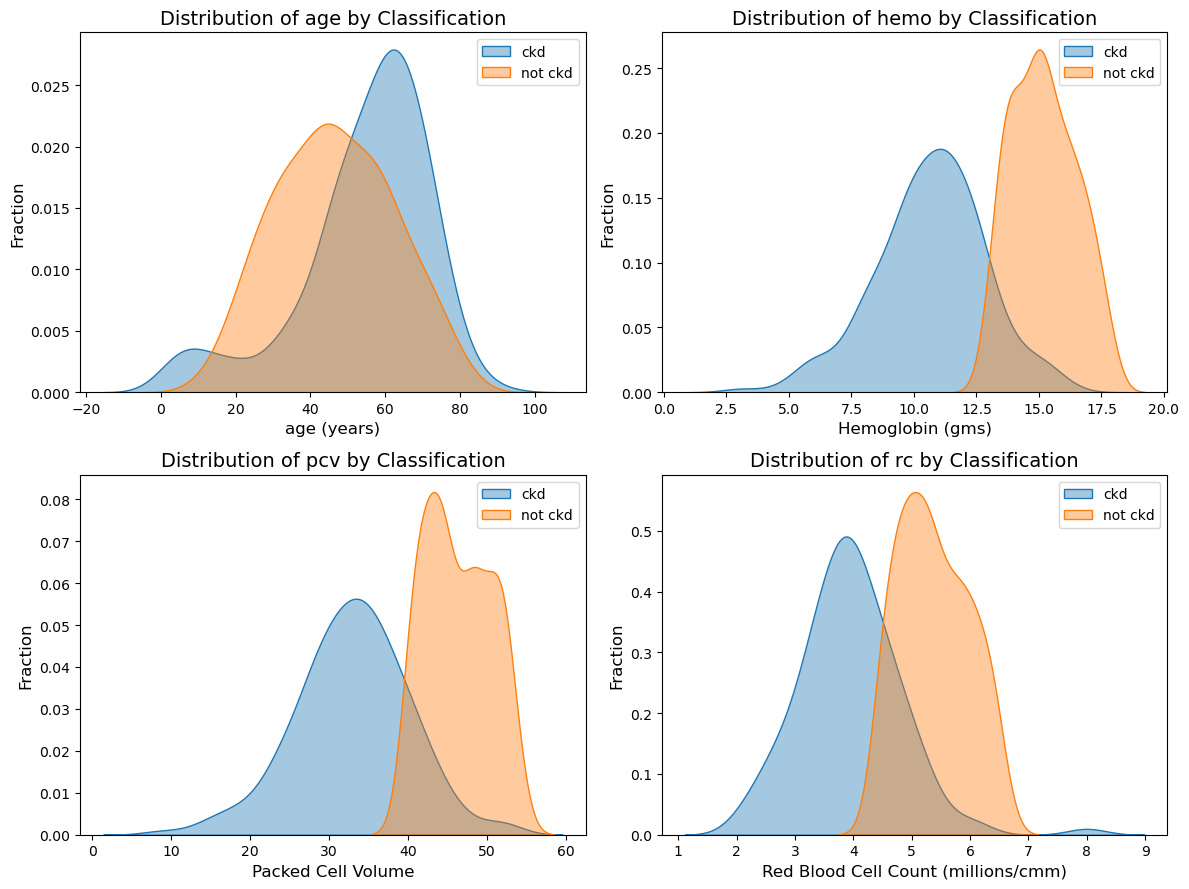

In [12]:
# plot the same attributes using histogram
plt.figure(figsize=(12, 9))
categories = df['classification'].unique()
full_name_cols = ['age (years)', 'Hemoglobin (gms)', 'Packed Cell Volume', 'Red Blood Cell Count (millions/cmm)']
for i, column in enumerate(vio_cols):
    plt.subplot(2,2,i+1) # Create subplots
    
    for c in categories:
        sns.kdeplot(df[df['classification'] == c][column], alpha=0.4, label=c, fill=True)
        plt.legend()
        plt.ylabel('Fraction', fontsize = 12)
        plt.xlabel(full_name_cols[i], fontsize = 12)
        plt.title(f'Distribution of {column} by Classification', fontsize = 14)

plt.tight_layout()
plt.show()

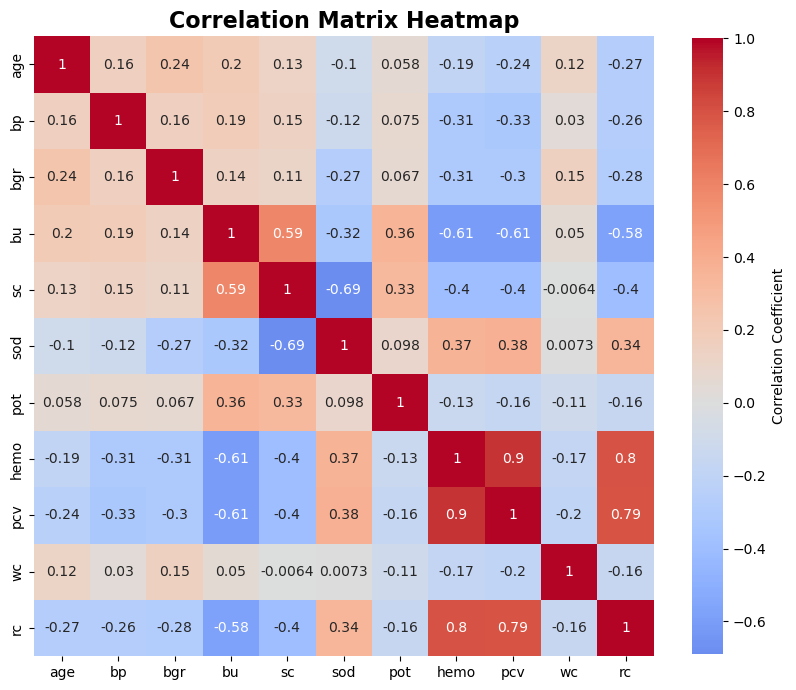

In [13]:
df_corr_nums = df[num_cols].corr(method='pearson')
plt.figure(figsize=(10, 10))
sns.heatmap(df_corr_nums, annot = True, cmap = 'coolwarm', center=0, cbar_kws={'label':'Correlation Coefficient', 'shrink': 0.8}, 
            square=True,  linecolor='black')

plt.title('Correlation Matrix Heatmap', fontsize=16, fontweight='bold')
plt.show()

we find hemo and pcv have strong correlation relationship, hence we choose to drop one of these attributes -- hemo.

In [14]:
df = df.drop(columns = 'hemo')
num_cols.remove('hemo')

### (iii) Next we take a look at the categorical variables with no order

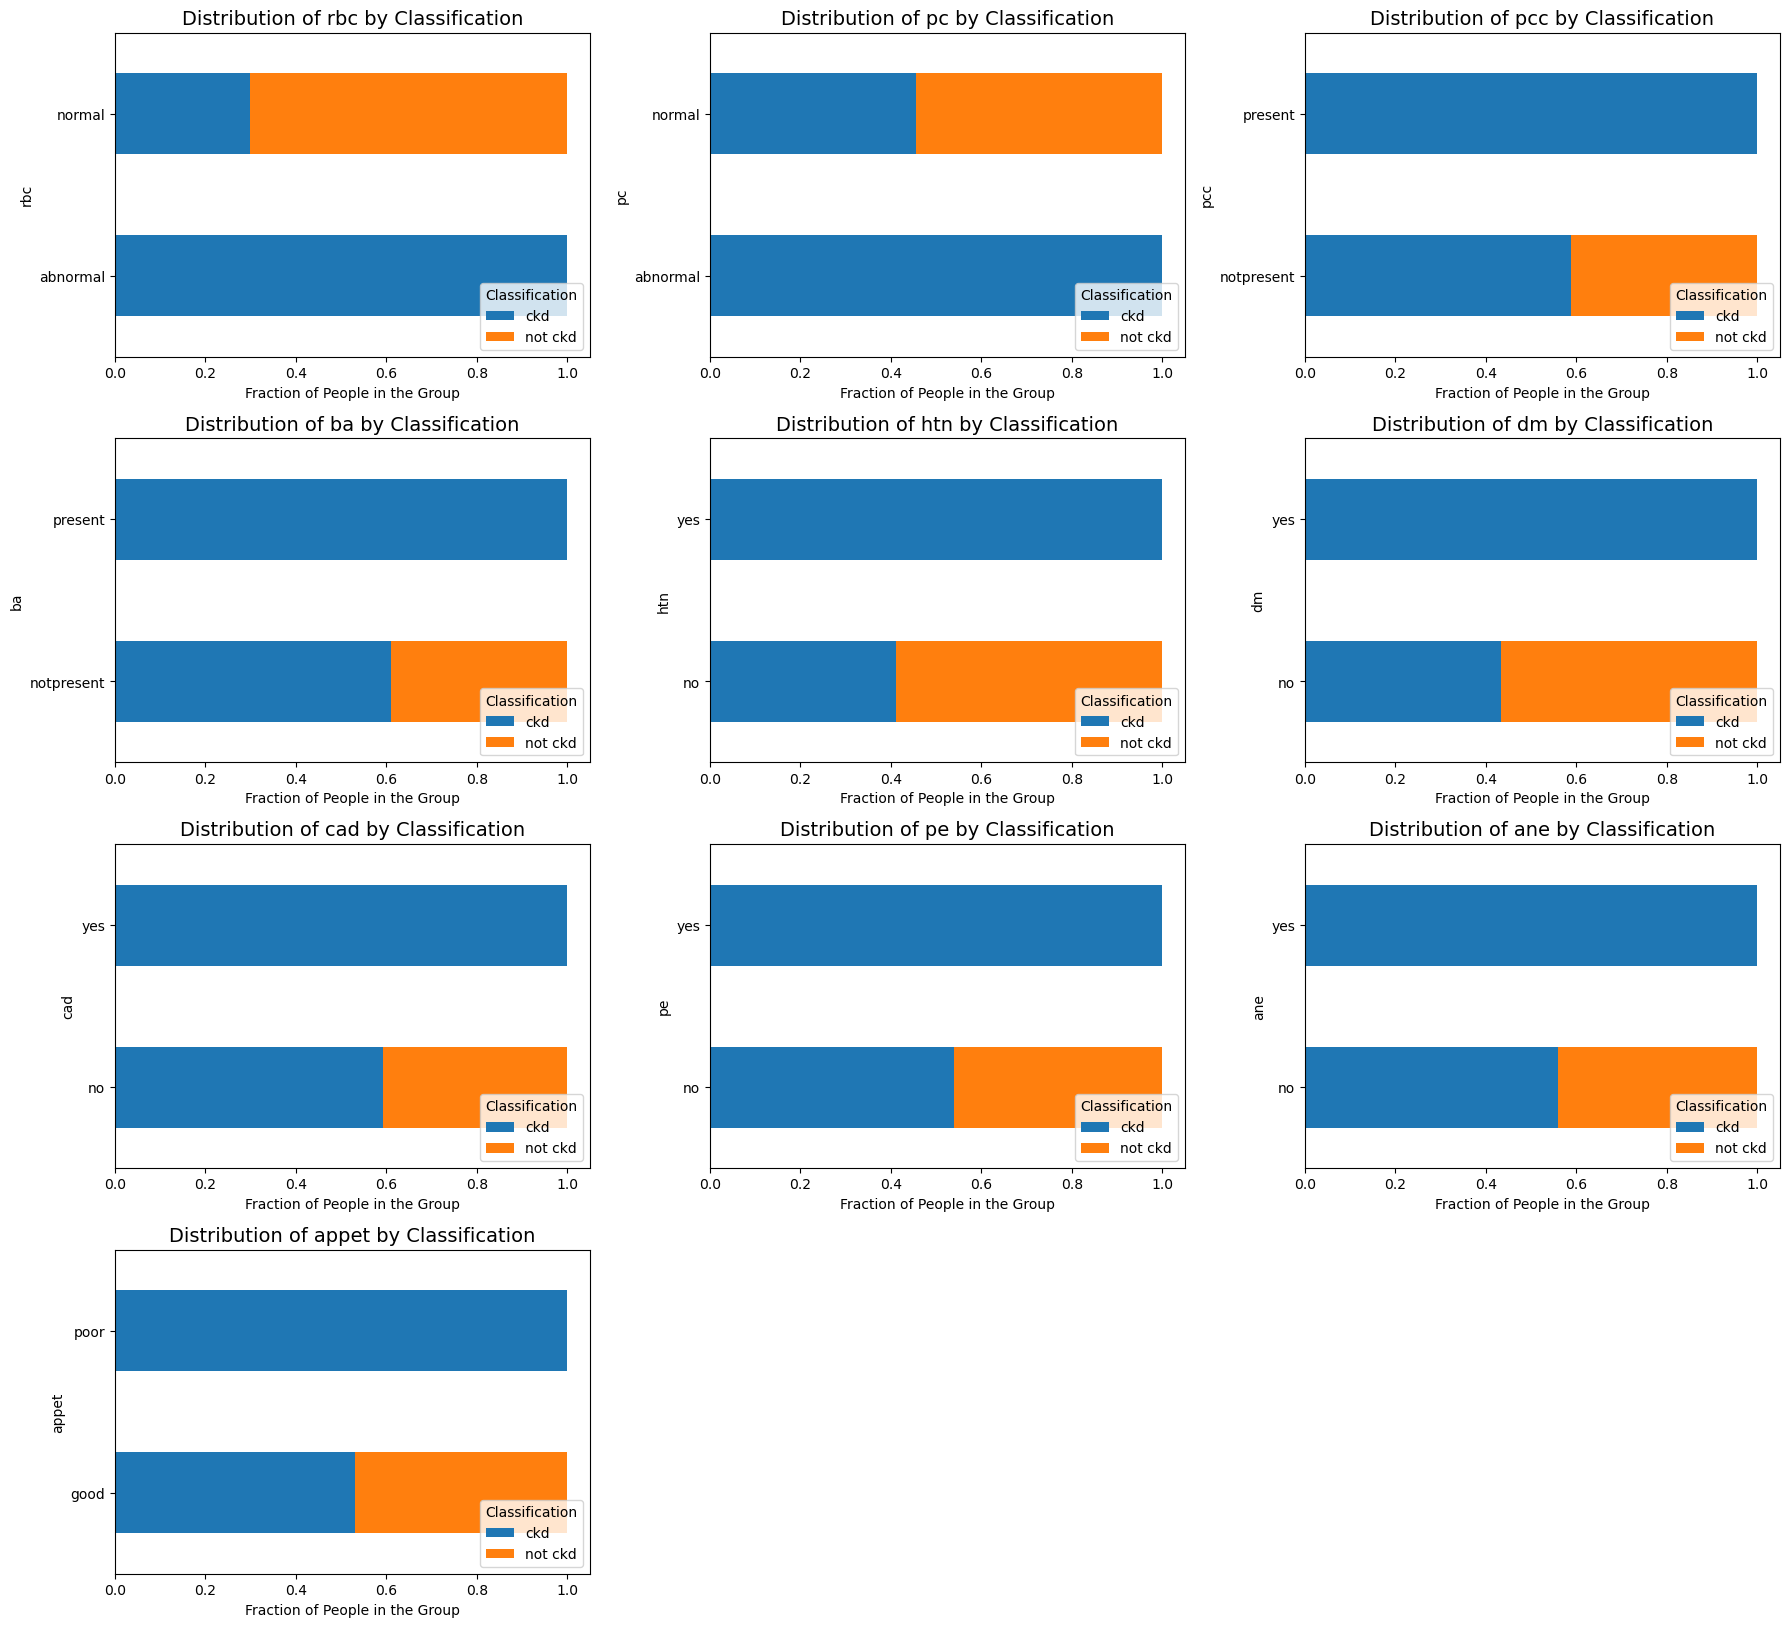

In [15]:
plt.figure(figsize=(18, 20))
categories = df['classification'].unique()
cat_cols = ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'pe', 'ane', 'appet']

for column in cat_cols:
    df[column] = df[column].str.strip()  # Remove any leading/trailing whitespace
    
for i, column in enumerate(cat_cols):
    plt.subplot(5, 3, i + 1)  # Use dynamic column count
    
    count_matrix = df.groupby([df[column], df['classification']]).size().unstack()
    count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1), axis=0)

    count_matrix_norm.plot(kind='barh', stacked=True, ax = plt.gca())  # Using the current axis

    plt.legend(title='Classification', fontsize=10, loc='lower right')
    plt.xlabel('Fraction of People in the Group')
    plt.title(f'Distribution of {column} by Classification', fontsize = 14)
    
plt.tight_layout()
plt.show()

We can find that all categorical attributes are binary. Also from the above stacked bar plot, we wonder if all not ckd happens in only one of the situation in all the binary attributes.

In [16]:
results = {}
for i in cat_cols:
    uni = df[i].dropna().unique()
    results[i] = [
        round(len(df[(df[i] == uni[0]) & (df['classification'] == 'not ckd')])/len(df[df[i] == uni[0]]),3),
        round(len(df[(df[i] == uni[0]) & (df['classification'] == 'ckd')])/len(df[df[i] == uni[0]]),3),
        round(len(df[(df[i] == uni[1]) & (df['classification'] == 'not ckd')])/len(df[df[i] == uni[1]]),3),
        round(len(df[(df[i] == uni[1]) & (df['classification'] == 'ckd')])/len(df[df[i] == uni[1]]),3)
    ]

pd.DataFrame(results, index = ['notckdS1', 'ckdS1', 'notckdS2', 'ckdS2'])

,rbc,pc,pcc,ba,htn,dm,cad,pe,ane,appet
notckdS1,0.701,0.544,0.412,0.39,0.00,0.000,0.407,0.461,0.44,0.47
ckdS1,0.299,0.456,0.588,0.61,1.00,1.000,0.593,0.539,0.56,0.53
notckdS2,0.000,0.000,0.000,0.00,0.59,0.567,0.000,0.000,0.00,0.00
ckdS2,1.000,1.000,1.000,1.00,0.41,0.433,1.000,1.000,1.00,1.00


### (iv) Do some summary statistics

In [17]:
df.shape

(400, 25)

Before preprocessing, we have 25 features and 400 data points(One feature is dropped because of colinearity)

In [18]:
df.describe()

,id,age,bp,sg,al,su,bgr,bu,sc,sod,pot,pcv,wc,rc
count,400.000000,391.000000,388.000000,353.000000,354.000000,351.000000,356.000000,381.000000,383.000000,313.000000,312.000000,329.000000,294.000000,269.000000
mean,199.500000,51.483376,76.469072,1.017408,1.016949,0.450142,148.036517,57.425722,3.072454,137.528754,4.627244,38.884498,8406.122449,4.707435
std,115.614301,17.169714,13.683637,0.005717,1.352679,1.099191,79.281714,50.503006,5.741126,10.408752,3.193904,8.990105,2944.474190,1.025323
min,0.000000,2.000000,50.000000,1.005000,0.000000,0.000000,22.000000,1.500000,0.400000,4.500000,2.500000,9.000000,2200.000000,2.100000
25%,99.750000,42.000000,70.000000,1.010000,0.000000,0.000000,99.000000,27.000000,0.900000,135.000000,3.800000,32.000000,6500.000000,3.900000
50%,199.500000,55.000000,80.000000,1.020000,0.000000,0.000000,121.000000,42.000000,1.300000,138.000000,4.400000,40.000000,8000.000000,4.800000
75%,299.250000,64.500000,80.000000,1.020000,2.000000,0.000000,163.000000,66.000000,2.800000,142.000000,4.900000,45.000000,9800.000000,5.400000
max,399.000000,90.000000,180.000000,1.025000,5.000000,5.000000,490.000000,391.000000,76.000000,163.000000,47.000000,54.000000,26400.000000,8.000000


## Data Cleaning & Preparation

In [19]:
for i in cat_cols:
    print(df[i].unique())

[nan 'normal' 'abnormal']
['normal' 'abnormal' nan]
['notpresent' 'present' nan]
['notpresent' 'present' nan]
['yes' 'no' nan]
['yes' 'no' nan]
['no' 'yes' nan]
['no' 'yes' nan]
['no' 'yes' nan]
['good' 'poor' nan]


In [20]:
# replace nan with string (another category)
for i in cat_cols:
    df.loc[:,i] = df[i].replace(to_replace = {np.nan:'missing'})

for i in cat_cols:
    print(df[i].unique())

['missing' 'normal' 'abnormal']
['normal' 'abnormal' 'missing']
['notpresent' 'present' 'missing']
['notpresent' 'present' 'missing']
['yes' 'no' 'missing']
['yes' 'no' 'missing']
['no' 'yes' 'missing']
['no' 'yes' 'missing']
['no' 'yes' 'missing']
['good' 'poor' 'missing']


In [21]:
# transfer the target variable from ['ckd','not ckd'] into 0s and 1s (easy for future analysis)
warnings.filterwarnings("ignore")
df['classification'] = pd.DataFrame(df['classification'].replace(to_replace={'ckd': 1, 'not ckd': 0}).reset_index(drop=True))

In [22]:
# Check the missing values percentage for each attribute
df.isnull().sum()/len(df)

id                0.0000
age               0.0225
bp                0.0300
sg                0.1175
al                0.1150
su                0.1225
rbc               0.0000
pc                0.0000
pcc               0.0000
ba                0.0000
bgr               0.1100
bu                0.0475
sc                0.0425
sod               0.2175
pot               0.2200
pcv               0.1775
wc                0.2650
rc                0.3275
htn               0.0000
dm                0.0000
cad               0.0000
appet             0.0000
pe                0.0000
ane               0.0000
classification    0.0000
dtype: float64

We can find the target variable doesn't contain missing values. And all attributes contain some missing values. And for the category variables, we can treat the missing values as another category. 

## Split and Preprocess the Dataset

In [23]:
# keep random state the same for spliting and training the model
np.random.seed(42) # for reproducibility
random_states = list(np.random.randint(1, 1000, size = 10))

In [24]:
X_train = []
y_train = []
X_val = []
y_val = []
X_test = []
y_test = []

X = df.loc[:, df.columns != 'classification']
y = df['classification']
for i in range(len(random_states)):
    # Split the data
    X_train_unit, X_other_unit, y_train_unit, y_other_unit = train_test_split(X, y, train_size = 0.6, random_state = random_states[i]) 
    X_val_unit, X_test_unit, y_val_unit, y_test_unit = train_test_split(X_other_unit, y_other_unit, train_size = 0.5, random_state = random_states[i])
    y_train.append(y_train_unit)
    y_val.append(y_val_unit)
    y_test.append(y_test_unit)
    
    # Define categorical and numerical features
    cat_cols_noorder = ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'pe', 'ane', 'appet']
    cat_cols_withorder = ['sg', 'al', 'su']
    
    # Preprocessing for the categorical data with no order -- OneHotEncoder
    colnames = []
    for k in cat_cols_noorder:
        temp = [f'{k}_{value}' for value in X_train_unit[k].unique()]
        colnames.extend(temp)
    enc = OneHotEncoder(sparse_output = False, handle_unknown = 'ignore')
    X_train_pre_cat1 = pd.DataFrame(enc.fit_transform(X_train_unit[cat_cols_noorder]), columns = colnames).reset_index(drop=True)
    X_test_pre_cat1 = pd.DataFrame(enc.transform(X_test_unit[cat_cols_noorder]), columns = colnames).reset_index(drop=True)
    X_val_pre_cat1 = pd.DataFrame(enc.transform(X_val_unit[cat_cols_noorder]), columns = colnames).reset_index(drop=True)
    
    # Preprocessing for the categorical data with order -- OrdinalEncoder
    ordinal_cats = [[1.005,1.010,1.015,1.020,1.025,np.nan], [0,1,2,3,4,5,np.nan], [0,1,2,3,4,5,np.nan]]
    enc = OrdinalEncoder(categories = ordinal_cats)
    X_train_pre_cat2 = pd.DataFrame(enc.fit_transform(X_train_unit[cat_cols_withorder]), columns = cat_cols_withorder).reset_index(drop=True)
    X_test_pre_cat2 = pd.DataFrame(enc.transform(X_test_unit[cat_cols_withorder]), columns = cat_cols_withorder).reset_index(drop=True)
    X_val_pre_cat2 = pd.DataFrame(enc.transform(X_val_unit[cat_cols_withorder]), columns = cat_cols_withorder).reset_index(drop=True)
    
    # Preprocessing for the continous variables -- StandardScalar
    scaler = StandardScaler()
    X_train_pre_num = pd.DataFrame(scaler.fit_transform(X_train_unit[num_cols]), columns = num_cols).reset_index(drop=True)
    X_test_pre_num = pd.DataFrame(scaler.transform(X_test_unit[num_cols]), columns = num_cols).reset_index(drop=True)
    X_val_pre_num = pd.DataFrame(scaler.transform(X_val_unit[num_cols]), columns = num_cols).reset_index(drop=True)

    # merge the table 
    X_train_merge = pd.concat([X_train_pre_num, X_train_pre_cat2, X_train_pre_cat1], axis = 1)
    X_val_merge = pd.concat([X_val_pre_num, X_val_pre_cat2, X_val_pre_cat1], axis = 1)
    X_test_merge = pd.concat([X_test_pre_num, X_test_pre_cat2, X_test_pre_cat1], axis = 1)

    # Apply StandardScalar to all the features
    X_train.append(pd.DataFrame(scaler.fit_transform(X_train_merge), columns = X_train_merge.columns))
    X_val.append(pd.DataFrame(scaler.transform(X_val_merge), columns = X_val_merge.columns))
    X_test.append(pd.DataFrame(scaler.transform(X_test_merge), columns = X_test_merge.columns))

## Choose ML model, Tune hyperparameter and Evaluate

### (i) XGBoosting

In [25]:
# Initialze empty variables
best_model_xgb = []
best_valscore_xgb = np.zeros(len(random_states))
test_score_xgb = np.zeros(len(random_states))
y_pred_xgb = []

for i in range(len(random_states)):
    # Define hyperparameter grid for tuning
    param_grid = {
        'max_depth': [1, 3],
        'leanrning_rate': [0.03],
        'n_estimators': [10000],    
        'reg_alpha': [1e-2, 1e-1, 0e0],
        'reg_lambda': [1e-2, 1e-1, 0e0]
    }
    
    val_score = np.zeros(len(ParameterGrid(param_grid)))
    models = []

    # train the model XGBoosting
    for p in range(len(ParameterGrid(param_grid))):
        params = ParameterGrid(param_grid)[p]
        clf = XGBClassifier(**params, early_stopping_rounds = 50, n_jobs = -1, random_state = random_states[i])
        clf.fit(X_train[i], y_train[i], eval_set = [(X_val[i], y_val[i])], verbose = False)
        models.append(clf)
        y_val_pred = clf.predict(X_val[i])
        val_score[p] = accuracy_score(y_val[i], y_val_pred)
    
    # get the best validation score
    best_valscore_xgb[i] = np.max(val_score)
    best_model_xgb.append(models[np.argmax(val_score)])
    
    # evaluate the model using test set (test score)
    y_test_pred = best_model_xgb[i].predict(X_test[i])
    test_score_xgb[i] = accuracy_score(y_test[i], y_test_pred)
    y_pred_xgb.append(y_test_pred)
        
    print('Random state: ', random_states[i])
    print('The best model parameters are: ', ParameterGrid(param_grid)[np.argmax(val_score)])
    print('Best validation score: ', best_valscore_xgb[i])
    print('Test accuracy: ', test_score_xgb[i])
    print(' ')

Random state:  103
The best model parameters are:  {'reg_lambda': 0.01, 'reg_alpha': 0.01, 'n_estimators': 10000, 'max_depth': 1, 'leanrning_rate': 0.03}
Best validation score:  0.9875
Test accuracy:  1.0
 
Random state:  436
The best model parameters are:  {'reg_lambda': 0.01, 'reg_alpha': 0.01, 'n_estimators': 10000, 'max_depth': 1, 'leanrning_rate': 0.03}
Best validation score:  1.0
Test accuracy:  0.9875
 
Random state:  861
The best model parameters are:  {'reg_lambda': 0.01, 'reg_alpha': 0.01, 'n_estimators': 10000, 'max_depth': 1, 'leanrning_rate': 0.03}
Best validation score:  1.0
Test accuracy:  1.0
 
Random state:  271
The best model parameters are:  {'reg_lambda': 0.01, 'reg_alpha': 0.01, 'n_estimators': 10000, 'max_depth': 1, 'leanrning_rate': 0.03}
Best validation score:  1.0
Test accuracy:  0.9875
 
Random state:  107
The best model parameters are:  {'reg_lambda': 0.01, 'reg_alpha': 0.01, 'n_estimators': 10000, 'max_depth': 1, 'leanrning_rate': 0.03}
Best validation score

In [26]:
print('The average test accuracy for xgb is', test_score_xgb.mean())
print('The test accuracy standard deviation for xgb is', test_score_xgb.std())
y_test_flatten = [item for sublist in y_test for item in sublist] 
y_pred_flatten = [item for sublist in y_pred_xgb for item in sublist] # get the y_true and y_pred
overall_accuracy_xgb = accuracy_score(y_test_flatten, y_pred_flatten)
print('The OVERALL test accuracy for xgb is', overall_accuracy_xgb)

The average test accuracy for xgb is 0.9925
The test accuracy standard deviation for xgb is 0.008291561975888493
The OVERALL test accuracy for xgb is 0.9925


When training with validation data, set a large n_estimators (e.g., 10000) and use early stopping to terminate the training once performance on the validation set stops improving. Here the test score stablized at 0.96875, because we set large n_estimators and use early stopping to avoid overfitting. And here other parameters become less important with those two parameters settled down. 

### (ii) Random Forest

In [27]:
# Before applying any other models, deal with missing values -- Multivariate Imputation (IterativeImputer)
warnings.filterwarnings("ignore", category=ConvergenceWarning) # Suppress the ConvergenceWarning
for i in range(len(random_states)):
    imputer = IterativeImputer(estimator = RandomForestRegressor(n_estimators = 50, n_jobs = -1), random_state = random_states[i])
    X_train[i] = pd.DataFrame(data = imputer.fit_transform(X_train[i]), columns = X_train[i].columns)
    X_val[i] = pd.DataFrame(data = imputer.transform(X_val[i]), columns = X_val[i].columns)
    X_test[i] = pd.DataFrame(data = imputer.transform(X_test[i]), columns = X_test[i].columns)

In [28]:
# Initialze empty variables
best_model_rf = []
best_valscore_rf = np.zeros(len(random_states))
test_score_rf = np.zeros(len(random_states))
y_pred_rf = []

for i in range(len(random_states)):
    # Define hyperparameter grid for tuning
    param_grid = {
        'n_estimators': [100],
        'max_depth': [1, 3, 5, 8, 13],
        'max_features': [1, 3, 5, 8, 13]
    }
    
    val_score = np.zeros(len(ParameterGrid(param_grid)))
    models = []

    # train the model random forest
    for p in range(len(ParameterGrid(param_grid))):
        params = ParameterGrid(param_grid)[p]
        clf = RandomForestClassifier(**params, n_jobs = -1, random_state = random_states[i])
        clf.fit(X_train[i], y_train[i])
        models.append(clf)
        y_val_pred = clf.predict(X_val[i])
        val_score[p] = accuracy_score(y_val[i], y_val_pred)
    
    # get the best validation score
    best_valscore_rf[i] = np.max(val_score)
    best_model_rf.append(models[np.argmax(val_score)])
    
    # evaluate the model using test set (test score)
    y_test_pred = best_model_rf[i].predict(X_test[i])
    test_score_rf[i] = accuracy_score(y_test[i], y_test_pred)
    y_pred_rf.append(y_test_pred)
        
    print('Random state: ', random_states[i])
    print('The best model parameters are: ', ParameterGrid(param_grid)[np.argmax(val_score)])
    print('Best validation score: ', best_valscore_rf[i])
    print('Test accuracy: ', test_score_rf[i])
    print(' ')

Random state:  103
The best model parameters are:  {'n_estimators': 100, 'max_features': 3, 'max_depth': 1}
Best validation score:  1.0
Test accuracy:  0.9875
 
Random state:  436
The best model parameters are:  {'n_estimators': 100, 'max_features': 8, 'max_depth': 3}
Best validation score:  1.0
Test accuracy:  0.9875
 
Random state:  861
The best model parameters are:  {'n_estimators': 100, 'max_features': 13, 'max_depth': 3}
Best validation score:  1.0
Test accuracy:  0.975
 
Random state:  271
The best model parameters are:  {'n_estimators': 100, 'max_features': 1, 'max_depth': 5}
Best validation score:  1.0
Test accuracy:  0.9875
 
Random state:  107
The best model parameters are:  {'n_estimators': 100, 'max_features': 5, 'max_depth': 1}
Best validation score:  1.0
Test accuracy:  0.9875
 
Random state:  72
The best model parameters are:  {'n_estimators': 100, 'max_features': 13, 'max_depth': 5}
Best validation score:  1.0
Test accuracy:  0.9875
 
Random state:  701
The best model 

In [29]:
print('The average test accuracy for rf is', test_score_rf.mean())
print('The test accuracy standard deviation for rf is', test_score_rf.std())
y_pred_flatten = [item for sublist in y_pred_rf for item in sublist]
overall_accuracy_rf = accuracy_score(y_test_flatten, y_pred_flatten)
print('The OVERALL test accuracy for rf is', overall_accuracy_rf)

The average test accuracy for rf is 0.9862500000000001
The test accuracy standard deviation for rf is 0.010383279828647594
The OVERALL test accuracy for rf is 0.98625


### (iii) SVM

In [30]:
# Initialze empty variables
best_model_svm = []
best_valscore_svm = np.zeros(len(random_states))
test_score_svm = np.zeros(len(random_states))
y_pred_svm = []

for i in range(len(random_states)):
    # Define hyperparameter grid for tuning
    param_grid = {
        'C': [1e-1, 1e0, 1e1, 1e2, 1e3, 1e4],
        'gamma':[1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1]
    }
    
    val_score = np.zeros(len(ParameterGrid(param_grid)))
    models = []

    # train the model SVM
    for p in range(len(ParameterGrid(param_grid))):
        params = ParameterGrid(param_grid)[p]
        clf = SVC(**params, probability = True, random_state = random_states[i]) # use SVC for classification problem
        clf.fit(X_train[i], y_train[i])
        models.append(clf)
        y_val_pred = clf.predict(X_val[i])
        val_score[p] = accuracy_score(y_val[i], y_val_pred)
    
    # get the best validation score
    best_valscore_svm[i] = np.max(val_score)
    best_model_svm.append(models[np.argmax(val_score)])
    
    # evaluate the model using test set (test score)
    y_test_pred = best_model_svm[i].predict(X_test[i])
    test_score_svm[i] = accuracy_score(y_test[i], y_test_pred)
    y_pred_svm.append(y_test_pred)
        
    print('Random state: ', random_states[i])
    print('The best model parameters are: ', ParameterGrid(param_grid)[np.argmax(val_score)])
    print('Best validation score: ', best_valscore_svm[i])
    print('Test accuracy: ', test_score_svm[i])
    print(' ')

Random state:  103
The best model parameters are:  {'gamma': 0.01, 'C': 10.0}
Best validation score:  1.0
Test accuracy:  1.0
 
Random state:  436
The best model parameters are:  {'gamma': 0.001, 'C': 10.0}
Best validation score:  1.0
Test accuracy:  1.0
 
Random state:  861
The best model parameters are:  {'gamma': 0.1, 'C': 1.0}
Best validation score:  0.9875
Test accuracy:  0.975
 
Random state:  271
The best model parameters are:  {'gamma': 0.1, 'C': 1.0}
Best validation score:  1.0
Test accuracy:  0.9875
 
Random state:  107
The best model parameters are:  {'gamma': 0.01, 'C': 10.0}
Best validation score:  1.0
Test accuracy:  1.0
 
Random state:  72
The best model parameters are:  {'gamma': 0.1, 'C': 1.0}
Best validation score:  1.0
Test accuracy:  0.9625
 
Random state:  701
The best model parameters are:  {'gamma': 0.01, 'C': 10.0}
Best validation score:  0.9875
Test accuracy:  1.0
 
Random state:  21
The best model parameters are:  {'gamma': 0.01, 'C': 1.0}
Best validation scor

In [31]:
print('The average test accuracy for svm is', test_score_svm.mean())
print('The test accuracy standard deviation for svm is', test_score_svm.std())
y_pred_flatten = [item for sublist in y_pred_svm for item in sublist]
overall_accuracy_svm = accuracy_score(y_test_flatten, y_pred_flatten)
print('The OVERALL test accuracy for rf is', overall_accuracy_svm)

The average test accuracy for svm is 0.985
The test accuracy standard deviation for svm is 0.02
The OVERALL test accuracy for rf is 0.985


### (iv) Logistic Regression with Elastic Net Regularization

In [32]:
# Initialze empty variables
best_model_logR = []
best_valscore_logR = np.zeros(len(random_states))
test_score_logR = np.zeros(len(random_states))
y_pred_logR = []

for i in range(len(random_states)):
    # Define hyperparameter grid for tuning
    param_grid = {
        'penalty': ['elasticnet'],
        'solver': ['saga'], 
        'l1_ratio': np.linspace(0,1,8),
        'C': [0.01, 0.05, 0.1, 0.5, 1, 1.5, 2]        
    }
    
    val_score = np.zeros(len(ParameterGrid(param_grid)))
    models = []

    # train the model
    for p in range(len(ParameterGrid(param_grid))):
        params = ParameterGrid(param_grid)[p]
        clf = LogisticRegression(**params, random_state = random_states[i])
        clf.fit(X_train[i], y_train[i])
        models.append(clf)
        y_val_pred = clf.predict(X_val[i])
        val_score[p] = accuracy_score(y_val[i], y_val_pred)
    
    # get the best validation score
    best_valscore_logR[i] = np.max(val_score)
    best_model_logR.append(models[np.argmax(val_score)])
    
    # evaluate the model using test set (test score)
    y_test_pred = best_model_logR[i].predict(X_test[i])
    test_score_logR[i] = accuracy_score(y_test[i], y_test_pred)
    y_pred_logR.append(y_test_pred)
        
    print('Random state: ', random_states[i])
    print('The best model parameters are: ', ParameterGrid(param_grid)[np.argmax(val_score)])
    print('Best validation score: ', best_valscore_logR[i])
    print('Test accuracy: ', test_score_logR[i])
    print(' ')

Random state:  103
The best model parameters are:  {'solver': 'saga', 'penalty': 'elasticnet', 'l1_ratio': 0.0, 'C': 0.05}
Best validation score:  1.0
Test accuracy:  1.0
 
Random state:  436
The best model parameters are:  {'solver': 'saga', 'penalty': 'elasticnet', 'l1_ratio': 0.14285714285714285, 'C': 0.05}
Best validation score:  1.0
Test accuracy:  0.975
 
Random state:  861
The best model parameters are:  {'solver': 'saga', 'penalty': 'elasticnet', 'l1_ratio': 0.0, 'C': 0.1}
Best validation score:  1.0
Test accuracy:  0.9875
 
Random state:  271
The best model parameters are:  {'solver': 'saga', 'penalty': 'elasticnet', 'l1_ratio': 0.0, 'C': 0.05}
Best validation score:  0.9875
Test accuracy:  0.9875
 
Random state:  107
The best model parameters are:  {'solver': 'saga', 'penalty': 'elasticnet', 'l1_ratio': 0.0, 'C': 0.5}
Best validation score:  1.0
Test accuracy:  0.9875
 
Random state:  72
The best model parameters are:  {'solver': 'saga', 'penalty': 'elasticnet', 'l1_ratio': 0

In [33]:
print('The average test accuracy for Logistic Regression with Elastic Net Regularization is', test_score_logR.mean())
print('The test accuracy standard deviation for Logistic Regression with Elastic Net Regularization is', test_score_logR.std())
y_pred_flatten = [item for sublist in y_pred_logR for item in sublist]
overall_accuracy_logR = accuracy_score(y_test_flatten, y_pred_flatten)
print('The OVERALL test accuracy for Logistic Regression with Elastic Net Regularization is', overall_accuracy_logR)

The average test accuracy for Logistic Regression with Elastic Net Regularization is 0.9812500000000002
The test accuracy standard deviation for Logistic Regression with Elastic Net Regularization is 0.011524430571616116
The OVERALL test accuracy for Logistic Regression with Elastic Net Regularization is 0.98125


### (v) KNN

In [34]:
# Initialze empty variables
best_model_knn = []
best_valscore_knn = np.zeros(len(random_states))
test_score_knn = np.zeros(len(random_states))
y_pred_knn = []

for i in range(len(random_states)):
    # Define hyperparameter grid for tuning
    param_grid = {
        'n_neighbors': [1, 3, 5, 10],  # Number of neighbors
        'weights': ['uniform', 'distance'],  # Weighting scheme
        'metric': ['euclidean', 'manhattan', 'minkowski'],  # Distance metrics
    }
    
    val_score = np.zeros(len(ParameterGrid(param_grid)))
    models = []

    # train the model
    for p in range(len(ParameterGrid(param_grid))):
        params = ParameterGrid(param_grid)[p]
        clf = KNeighborsClassifier(**params)
        clf.fit(X_train[i], y_train[i])
        models.append(clf)
        y_val_pred = clf.predict(X_val[i])
        val_score[p] = accuracy_score(y_val[i], y_val_pred)
    
    # get the best validation score
    best_valscore_knn[i] = np.max(val_score)
    best_model_knn.append(models[np.argmax(val_score)])
    
    # evaluate the model using test set (test score)
    y_test_pred = best_model_knn[i].predict(X_test[i])
    test_score_knn[i] = accuracy_score(y_test[i], y_test_pred)
    y_pred_knn.append(y_test_pred)
        
    print('Random state: ', random_states[i])
    print('The best model parameters are: ', ParameterGrid(param_grid)[np.argmax(val_score)])
    print('Best validation score: ', best_valscore_knn[i])
    print('Test accuracy: ', test_score_knn[i])
    print(' ')

Random state:  103
The best model parameters are:  {'weights': 'uniform', 'n_neighbors': 1, 'metric': 'manhattan'}
Best validation score:  1.0
Test accuracy:  0.9875
 
Random state:  436
The best model parameters are:  {'weights': 'uniform', 'n_neighbors': 1, 'metric': 'euclidean'}
Best validation score:  0.9875
Test accuracy:  0.975
 
Random state:  861
The best model parameters are:  {'weights': 'uniform', 'n_neighbors': 1, 'metric': 'euclidean'}
Best validation score:  0.9875
Test accuracy:  0.9875
 
Random state:  271
The best model parameters are:  {'weights': 'uniform', 'n_neighbors': 1, 'metric': 'euclidean'}
Best validation score:  0.975
Test accuracy:  0.95
 
Random state:  107
The best model parameters are:  {'weights': 'uniform', 'n_neighbors': 1, 'metric': 'manhattan'}
Best validation score:  1.0
Test accuracy:  0.9875
 
Random state:  72
The best model parameters are:  {'weights': 'uniform', 'n_neighbors': 1, 'metric': 'euclidean'}
Best validation score:  1.0
Test accuracy

In [35]:
print('The average test accuracy for KNN is', test_score_knn.mean())
print('The test accuracy standard deviation for KNN is', test_score_knn.std())
y_pred_flatten = [item for sublist in y_pred_knn for item in sublist]
overall_accuracy_knn = accuracy_score(y_test_flatten, y_pred_flatten)
print('The OVERALL test accuracy for Logistic KNN is', overall_accuracy_knn)

The average test accuracy for KNN is 0.9762500000000001
The test accuracy standard deviation for KNN is 0.013050383136138212
The OVERALL test accuracy for Logistic KNN is 0.97625


### Summary of result

In [36]:
# get the baseline score from aggregation all y_test
x = sum(y_test_flatten)/len(y_test_flatten)
if x >= 0.5:
    baseline_score = x
else:
    baseline_score = 1 - x
print(baseline_score)

0.59


In [45]:
test_score_sum = pd.DataFrame({'XGBoosting': test_score_xgb, 
                               'Random_forest': test_score_rf,
                               'SVM': test_score_svm,
                               'Logistic': test_score_logR,
                               'KNN': test_score_knn})
print(test_score_sum)

   XGBoosting  Random_forest     SVM  Logistic     KNN
0      1.0000         0.9875  1.0000    1.0000  0.9875
1      0.9875         0.9875  1.0000    0.9750  0.9750
2      1.0000         0.9750  0.9750    0.9875  0.9875
3      0.9875         0.9875  0.9875    0.9875  0.9500
4      0.9750         0.9875  1.0000    0.9875  0.9875
5      0.9875         0.9875  0.9625    0.9750  0.9875
6      0.9875         0.9625  1.0000    0.9625  0.9750
7      1.0000         1.0000  0.9875    0.9875  0.9625
8      1.0000         0.9875  1.0000    0.9875  0.9875
9      1.0000         1.0000  0.9375    0.9625  0.9625


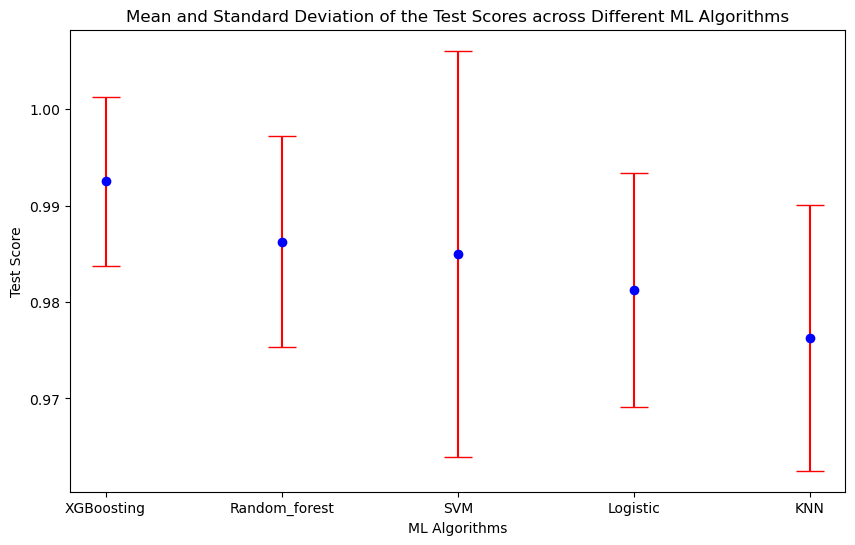

XGBoosting       0.99250
Random_forest    0.98625
SVM              0.98500
Logistic         0.98125
KNN              0.97625
dtype: float64


In [64]:
test_mean = test_score_sum.mean()
test_std = test_score_sum.std()
# plot means and standard deviations of test scores
plt.figure(figsize = (10,6))
plt.errorbar(x = test_mean.index, y = test_mean, yerr = test_std, fmt ='o',color='blue', ecolor='red', capsize=10)
plt.xlabel('ML Algorithms')
plt.ylabel('Test Score')
plt.title('Mean and Standard Deviation of the Test Scores across Different ML Algorithms')
plt.show()
print(test_score_sum.mean())

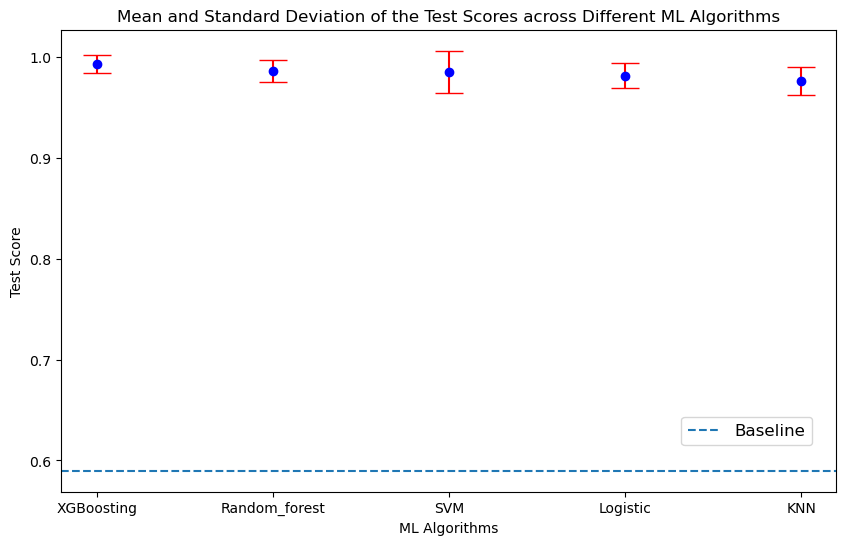

In [80]:
# add a baseline on the plot
plt.figure(figsize = (10,6))
plt.errorbar(x = test_mean.index, y = test_mean, yerr = test_std, fmt ='o',color='blue', ecolor='red', capsize=10)
plt.xlabel('ML Algorithms')
plt.ylabel('Test Score')
plt.title('Mean and Standard Deviation of the Test Scores across Different ML Algorithms')
plt.axhline(baseline_score, linestyle='--', label='Baseline')
plt.legend(loc= (0.8, 0.1), fontsize = 12)
plt.show()

## Model Inspectation
Here we choose to use XGBoosting model because it has the highest accuracy score, and then we use the y_pred from this model to do the model inspection.
### (i) confusion matrix

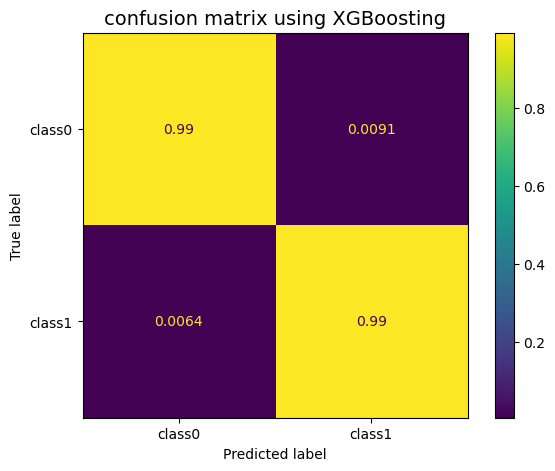

In [88]:
# 1. confusion matrix using XGBoosting
cm = confusion_matrix(y_test_flatten, [item for sublist in y_pred_xgb for item in sublist], normalize = 'true')
disp = ConfusionMatrixDisplay(cm, display_labels = ['class0', 'class1'])
fig, ax = plt.subplots(figsize = (7,5))
disp.plot(ax=ax)
plt.title('confusion matrix using XGBoosting', fontsize = 14)
plt.show()

### (ii) feature importance